**데이터 로드 및 정규화**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 정규화 설정
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터셋 작성
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# 데이터 로더 작성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**데이터 확인 (option)**

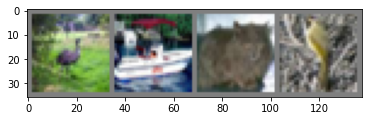

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**모델 구축**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

 bird  ship   cat  bird


**loss function & optimizer 설정**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

**학습 진행**

In [ ]:
for epoch in range(1):   # 전체 데이터셋을 여러번 반복하기

    training_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader):
        # 입력 받기: 데이터는 [inputs, labels] 형태의 리스트
        inputs, labels = data

        # 파라미터 변화도를 0으로 만들기
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels) # 손실을 계산
        loss.backward() # 파라미터들의 에러에 대한 변화도를 계산하여 누적함
        optimizer.step() # loss function를 효율적으로 최소화 할 수 있게 파라미터 수정
        
        # 통계 출력
        training_loss += loss.item()
        if i % 2000 == 1999:    # 미니배치 2000개 마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, training_loss / 2000))
            training_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.201
[1,  4000] loss: 1.907
[1,  6000] loss: 1.693
[1,  8000] loss: 1.616
[1, 10000] loss: 1.530
[1, 12000] loss: 1.496
Finished Training


**검증 진행**

In [ ]:
from tqdm import tqdm

val_loss = 0.0
corrects = 0
model.eval()
for i, data in tqdm(enumerate(testloader)):
    # 입력 받기: 데이터는 [inputs, labels] 형태의 리스트
    inputs, labels = data
    # print(inputs.size)

    # 순전파 + 역전파 + 최적화
    outputs = model(inputs)
    loss = criterion(outputs, labels) # 손실을 계산
    _, preds = torch.max(outputs, 1)  # 라벨을 예측
    
    # 통계 출력
    val_loss += loss.item()
    corrects += torch.sum(preds == labels.data)

val_loss = val_loss / (i+1)
val_acc = corrects / len(testloader.dataset)
print('val Loss: {:.4f} val Acc: {:.4f}'.format(val_loss, val_acc))

2500it [00:07, 325.31it/s]

val Loss: 1.4612 val Acc: 0.4766


**test 데이터로 inference**

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


원본 크기: (426, 640, 3)
resize 크기: (32, 32, 3)
transform 크기: torch.Size([3, 32, 32])

tensor([[-2.0739, -3.5266,  1.0433,  3.5239, -0.9031,  3.6159,  0.5949,  0.7028,
         -1.9401, -1.3515]], grad_fn=<AddmmBackward0>)
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


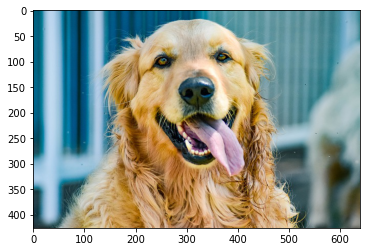

예측 class: dog


In [ ]:
from PIL import Image

# test 이미지 불러오기
image_file_path = '/content/drive/MyDrive/소프트웨어응용/1차시실습/data/goldenretriever-3724972_640.jpg'
img_origin = Image.open(image_file_path)  # [높이][너비][색RGB]
print('원본 크기:', np.shape(img_origin))

# 데이터 전처리
img = img_origin.resize((32, 32))
print('resize 크기:', np.shape(img))
input = transform(img)
print('transform 크기:', input.size())
print()

# inference
model.eval()
output = model(input) # 모델에 입력 넣기
print(output)
_, preds = torch.max(output, 1)  # 라벨을 예측
print(classes)

# 결과 시각화
plt.imshow(img_origin)
plt.show()
print('예측 class:', classes[preds[0]])

In [ ]:
softmax = nn.Softmax(dim=1)
soft_out = softmax(output)
print(soft_out)

print(torch.sum(soft_out).item())

tensor([[1.5964e-03, 3.7347e-04, 3.6052e-02, 4.3075e-01, 5.1477e-03, 4.7230e-01,
         2.3025e-02, 2.5649e-02, 1.8250e-03, 3.2878e-03]],
       grad_fn=<SoftmaxBackward0>)
1.0
